In [1]:
using Images, Plots, FFTW
using JuMP, GLPK
using LinearAlgebra

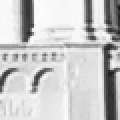

In [2]:
s = 60
img = Gray.(load("building.tif"))[100 .+ (1:s), 0 .+ (1:s)]

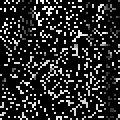

In [3]:
U = Float16
sampling_density = 0.2
sampling_matrix = rand(U, size(img)) .< sampling_density
sampled_image = sampling_matrix .* img
# Vector form is building[sampling_matrix]

In [4]:
function optimizer(sampled_image, sampling_matrix; lambda = 5.)
    U = Float16
    image_as_array = convert(Array{U}, channelview(sampled_image))
    
    # For grayscale input
    if ndims(image_as_array) == 2
        image_as_array = reshape(image_as_array, 1, size(image_as_array)...)
    end
    
    nsamples = sum(sampling_matrix)
    nc, nx, ny = size(image_as_array)
    
    IDCTx = idct(I(nx), 1)
    IDCTy = idct(I(ny), 2)
    
    model = Model(GLPK.Optimizer)
    set_optimizer_attribute(model, "msg_lev", GLPK.GLP_MSG_ALL)
    
    @variable(model, fft_pred[1:nc, 1:nx, 1:ny]) 
    @variable(model, t[1:nc, 1:nx, 1:ny])
    
    @constraint(model, tAbs1[i in 1:nc, j in 1:nx, k in 1:ny],
                - t[i, j, k] ≤ fft_pred[i, j, k])
    @constraint(model, tAbs2[i in 1:nc, j in 1:nx, k in 1:ny],
                fft_pred[i, j, k] ≤ t[i, j, k])
        
    for j in 1:nx, k in 1:ny
        if sampling_matrix[j, k]
            for ch in 1:nc
                @constraint(model, (IDCTx * fft_pred[ch, :, :] * IDCTy)[j, k]
                                    == image_as_array[ch, j, k])
            end
        end
    end
    
    @objective(model, Min, sum(t))
        
    optimize!(model)
    print(solution_summary(model))
    return value.(fft_pred), colorview(RGB, idct(value.(fft_pred), (2, 3)))
end

optimizer (generic function with 1 method)

In [ ]:
@time res, img = optimizer(sampled_image, sampling_matrix);

In [ ]:
[sampled_image img]

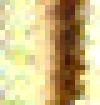

In [109]:
img

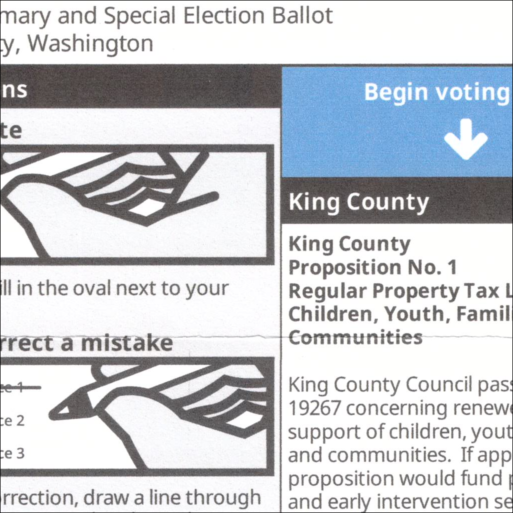

In [2]:
ballot = load("ballot.tif")